# **SolvingMazes-Policy_Iteration**

### Create Maze

In [1]:
%%writefile ./maze0.txt
############B###############
## ### #####              ##
## ### #####  #### ### ##  #
#                  ### ### #
# ### ################ ### #
# ### #####            ### #
# ###       # #### ## ###  #
# #### #### #  #### # #### #
# ##    ### # #            #
#  ### #### # ######## ### #
## ##   ###       #### ### #
## #### #### #### #### ### #
## #### #### #### #### ### #
##                         #
###A########################

Overwriting ./maze0.txt


In [ ]:
#Load Maze
with open('./maze0.txt') as f:
    contents = f.read()

In [ ]:
print(contents)

In [20]:
import sys
import numpy as np
import sklearn.preprocessing as sc
import matplotlib.pyplot as plt
import cv2
import operator
        
class PolicyIteration4SolveMaze():

    def __init__(self, contents):
                
        """# Read file and set height and width of maze
        with open(filename) as f:
            contents = f.read()"""
        
        # Validate start and goal
        if contents.count("A") != 1:
            raise Exception("maze must have exactly one start point")
        if contents.count("B") != 1:
            raise Exception("maze must have exactly one goal")
        
        self.actions =  ["up", "down", "left", "right"]
        
        # Determine height and width of maze
        contents = contents.splitlines()
        self.height = len(contents)
        self.width = max(len(line) for line in contents)
        self.states = []
        self.gamma = .9 # This is the discount factor
        self.theta = .00001 # Small number threshold to signal convergence of the value function
        self.probs = [round(1/len(self.actions),2)] * len(self.actions)
        self.policy = list(zip(self.actions,self.probs))
        
        # Keep track of walls
        self.walls = []
        self.wall_cords = []
        for i in range(self.height):
            row = []
            for j in range(self.width):
                try:
                    if contents[i][j] == "A":
                        self.start = (i, j)
                        row.append(False)
                        self.states.append((i,j))
                    elif contents[i][j] == "B":
                        self.goal = (i, j)
                        row.append(False)
                        self.states.append((i,j))
                    elif contents[i][j] == " ":
                        row.append(False)
                        self.states.append((i,j))
                    else:
                        row.append(True)
                        self.wall_cords.append((i,j))
                except IndexError:
                    row.append(False)
                    self.states.append((i,j))
            self.walls.append(row)
            

        self.state_count = len(self.states)
        self.solution = None
        self.V = dict(zip(self.states, self.state_count*[0]))
        self.pi = dict(zip(self.states, self.state_count*[0]))
        for s in self.states:
            avail_actions = self.actions
            self.pi[s] = avail_actions[0]
        self.pi1 = dict(zip(self.states, self.state_count*[0]))
        
    def print(self):
        solution = self.solution[1] if self.solution is not None else None
        print()
        for i, row in enumerate(self.walls):
            for j, col in enumerate(row):
                if col:
                    print("#", end="")
                elif (i, j) == self.start:
                    print("A", end="")
                elif (i, j) == self.goal:
                    print("B", end="")
                elif solution is not None and (i, j) in solution:
                    print("*", end="")
                else:
                    print(" ", end="")
            print()
        print()


    def neighbors(self, state, a = None):
        """This function takes in a state and returns all available actions for that state the next state 
            and reward if each action is take, with a specific transition probability"""
        row, col = state
        candidates = [
            ("up", (row - 1, col)),
            ("down", (row + 1, col)),
            ("left", (row, col - 1)),
            ("right", (row, col + 1))
        ]

        result = []
        for action, (r, c) in candidates:
            if 0 <= r < self.height and 0 <= c < self.width and not self.walls[r][c]:
                reward = 10000000 if ((r,c) == self.goal) or (state == self.goal) else -1
                trans_prob = 1
                result.append((action, (r, c), reward, trans_prob))
                
        actions = [tup[0] for tup in result]

        if a:
            R = []
            if a in actions:
                inx = actions.index(a)
                R.append((result[inx]))
                return R
            else: 
                R.append((a, (row,col), -15, 1))
                return R
        return result
          
    def bellmans_update(self, s,V):
        v = dict(zip(self.actions,len(self.actions) * [0]))
        for a , prob in self.policy:
            for (_,next_state, r, p) in self.neighbors(s,a):
                v[a] += prob * p * (r + self.gamma * V[next_state])
        return sum(v.values())
    
        
    # POLICY EVALUATION - Inplace
    def policy_eval_in_place(self):  
        V = dict(zip(self.states, self.state_count*[0]))
        phi = sum(V.values())
        while True:
            delta = 0
            for s in self.states:
                vv = self.bellmans_update(s,V) 
                V[s]= vv
                delta = max(delta, np.abs(phi - sum(V.values())))
            # Stop evaluating once our value function change is below a threshold
            if delta < self.theta:
                break
            phi = sum(V.values())
        return V
    
    def one_step_lookahead(self,s,V):
        """
        Helper function to calculate the value for all action in a given state.

        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS

        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        A = dict(zip(self.actions,len(self.actions) * [0]))
        for a, action_prob, in self.policy:
            for (_,next_state, r, p) in self.neighbors(s,a):
                A[a] += action_prob * p * (r + self.gamma * V[next_state])
        return A 
    
    def plot_state_values(self):
        val = np.array(list(self.V.values())).reshape(-1,1)
        va = sc.MinMaxScaler(feature_range=(0, 255)).fit_transform(val).flatten()
        V = {}
        for i in range(len(va)):
            V[list(self.V.keys())[i]] = va[i]

        # create a black image
        img  = np.ones((self.height,self.width,3), np.uint8)

        for item in V.items():
            (r,c),vx = item
            img[r,c] = [0,vx,0]

        for r,c in self.wall_cords:
            img[r,c] = [150,5,150]

        img[self.start[0],self.start[1]] = [255,0,0]
        img[self.goal[0],self.goal[1]] = [0,0,255]
        def showimg(img):
            plt.figure(figsize = (15,15))
            plt.imshow(img, cmap='viridis')
            plt.xticks([])
            plt.yticks([])
            #plt.colorbar()
            plt.show()
        showimg(img)
        
        def policy_(s):
            row, col = s
            candidates = [
                ("up", (row - 1, col)),
                ("down", (row + 1, col)),
                ("left", (row, col - 1)),
                ("right", (row, col + 1))
            ]


            if s in self.wall_cords:
                return ('This state is in the wall')
            else:
                values = {a:self.V[r,c] for a,(r,c) in candidates if 0<=r<self.height and 0<=c<self.width and not self.walls[r][c]}
                values = {v:k for k,v in values.items()}
                best = values[max(values)]
            return best
        
        pi = np.zeros((self.height, self.width)).astype('str')
        pi = np.where(pi=='0.0', 'wall', pi)
        candidates = {
                    "up": [255,0,0],
                    "down": [0,0,255],
                    "left": [0,255,0],
                    "right": [255,255,0]
        }
        for item in self.pi.keys():
            action = policy_(item)
            r,c = item
            pi[r,c] = action
            img[r,c] = candidates[action]

        def showimg(img):
            plt.figure(figsize = (15,15))
            plt.imshow(img, cmap='viridis', )
            plt.yticks(list(range(self.height)))
            plt.xticks(list(range(self.width)))
            plt.title("POLICY\n\nRED  =>  up\nBLUE  =>  down\nGREEN  =>  left\nYELLOW  =>  right")
            #plt.colorbar()
            plt.show()
        showimg(img)
        return img
    
    
    def solve_policy_iteration(self):
        print('Maze before policy iteration')
        img = self.plot_state_values()
        while True:
            stable_state = True
            self.V = self.policy_eval_in_place()
            
            self.pi2 = dict(zip(self.states, self.state_count*[0]))
            for s in self.states:
                samples = { k:v for k,v in self.one_step_lookahead(s,self.V).items() if k in [a for a,_,_1,_2 in self.neighbors(s)]}
                best_choice = max(samples.items(), key=operator.itemgetter(1))
                self.pi2[s] = best_choice[0]
                self.V[s] = best_choice[1]
                self.pi1[s] = samples
            if self.pi != self.pi2:
                stable_state = False
                self.pi  = self.pi2
            else:
                break
        print('Maze is solved. Call print solution\n\n')
        print('Maze After policy iteration')
        img = self.plot_state_values()
    
m = PolicyIteration4SolveMaze(contents = contents)

Maze before policy iteration


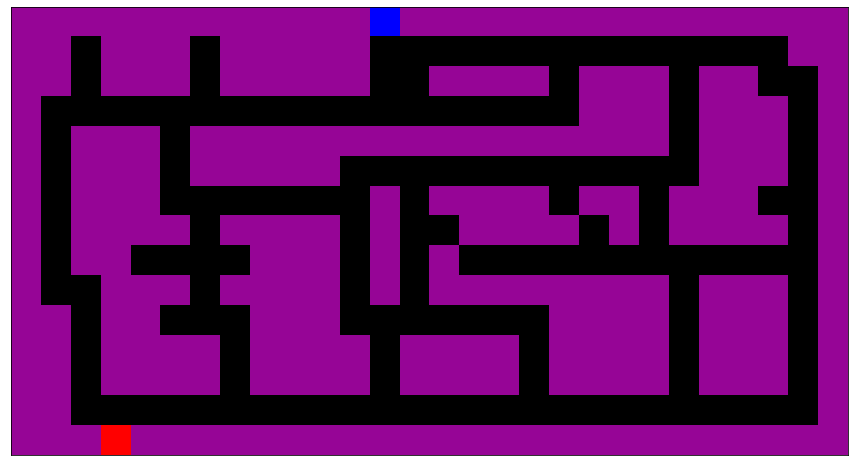

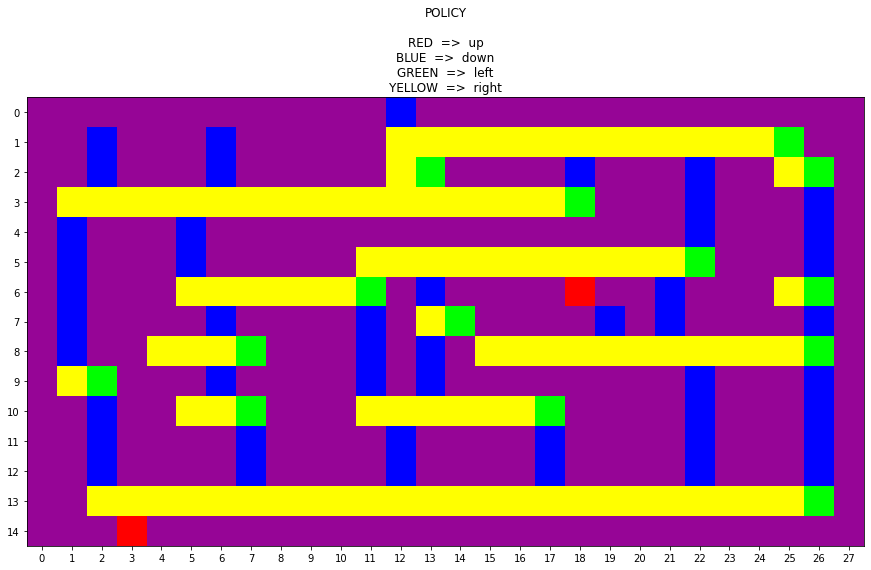

Maze is solved. Call print solution


Maze After policy iteration


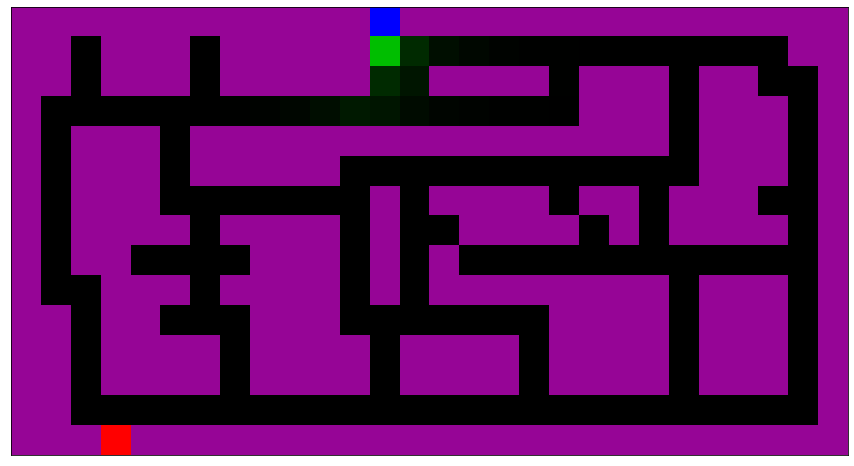

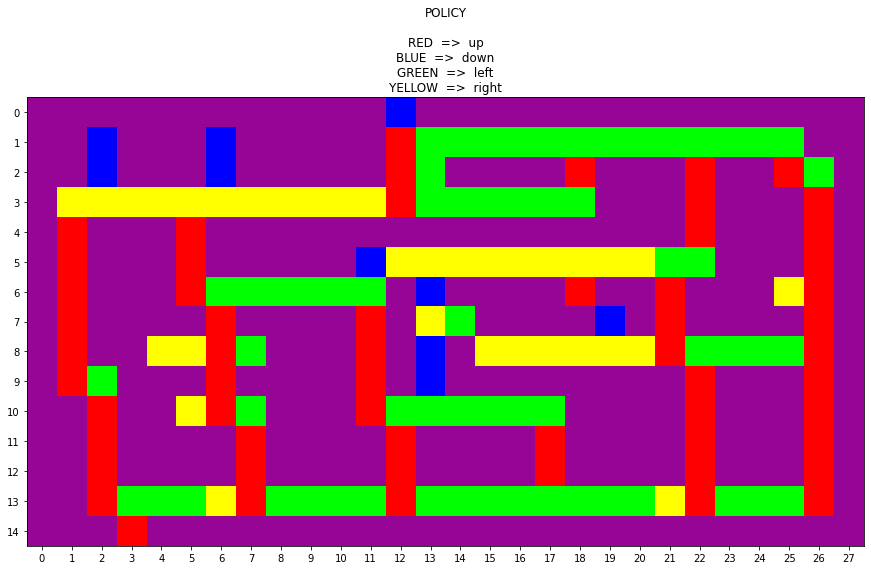

In [21]:
m.solve_policy_iteration()